This is needed to reload modules without restarting the kernel

In [2]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [3]:
import os
os.sys.path.append('../../')


Base Packages

In [4]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

Base plotting style

In [5]:
import mplhep as hep
hep.set_style('ATLAS')

# Investigating  $X_{HH}$ shape

Lets investigate the $X_{HH}$ shape as a function of the massplane
- signal sample (4b, SR)
- data sample (2b, SR) + Reweighting 

(begin with 2018 for simplicity)

In [6]:
#Signal MC 2018 file_path
file_path_mc_18 = "/mnt/storage/lborgna/NNT/MDR_VEC/mc/mc16e_2b_shiftKR_lshi.root"

In [7]:
#data 2018 file_path
file_path_data_18  = '/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_18_NN_100_bootstraps.root'

**Loading Data and signal**

In [8]:
columns_to_load = ['event_number','run_number','ntag','kinematic_region','m_hh','m_h1','m_h2','dEta_hh']

In [9]:
from hh4b_utils.nnt_tools import load_nnt

In [10]:
signal = load_nnt(file_path_mc_18, trees=['control','validation','sig'], columns=columns_to_load+['mc_sf'])

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


In [11]:
data = load_nnt(file_path_data_18, trees=['control','validation','sig'], columns=columns_to_load+['NN_d24_weight_bstrap_med_18'])

100%|██████████| 164/164 [00:25<00:00,  6.42it/s]


In [12]:
from hh4b_utils.nnt_tools import xhh, vrhh, crhh

In [13]:
x,y = np.linspace(50, 200, 1000), np.linspace(50, 200, 1000)

In [14]:
X, Y = np.meshgrid(x, y)

In [15]:
for _df in [signal, data]:
    _df['Xhh'] = xhh(_df.m_h1.values, _df.m_h2.values, m_h1_center=124, m_h2_center=117)

In [17]:
f_data.keys()

NameError: name 'f_data' is not defined

In [18]:
f_sig = uproot.open(file_path_mc_18)
f_data = uproot.open(file_path_data_18)

In [19]:
from hh4b_utils.nnt_tools import get_mu, get_mu_iqr,w_col

In [20]:
columns_to_load

['event_number',
 'run_number',
 'ntag',
 'kinematic_region',
 'm_hh',
 'm_h1',
 'm_h2',
 'dEta_hh']

In [21]:
norm = get_mu(f_data, 18)

In [22]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063804 entries, 0 to 4063803
Data columns (total 10 columns):
event_number                   int64
run_number                     int32
ntag                           int32
kinematic_region               int8
m_hh                           float32
m_h1                           float32
m_h2                           float32
dEta_hh                        float32
NN_d24_weight_bstrap_med_18    float64
Xhh                            float32
dtypes: float32(5), float64(1), int32(2), int64(1), int8(1)
memory usage: 174.4 MB


In [23]:
data['NN_weight'] = norm * data['NN_d24_weight_bstrap_med_18']

In [24]:
lumi=58.45

In [25]:
mask_sig_4b = signal['ntag']>=4

In [26]:
from hh4b_utils.plot_tools import hist2d, hist2d_ratio

In [27]:
from matplotlib.lines import Line2D


No handles with labels found to put in legend.


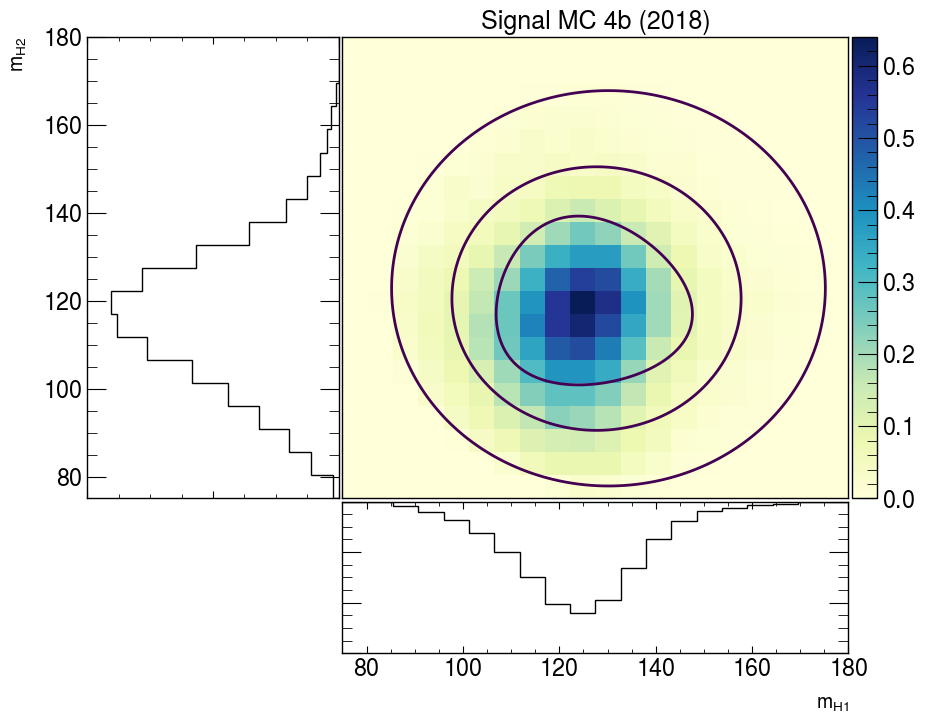

In [28]:
h_sig = hist2d(
    signal.loc[mask_sig_4b, "m_h1"].values,
    signal.loc[mask_sig_4b, "m_h2"].values,
    xrange=(75, 180),
    yrange=(75, 180),
    bins=(20,20),
    axis_hist_on=True,
    weights=lumi * signal.loc[mask_sig_4b,'mc_sf'].values,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'Signal MC 4b (2018)'
)
h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45])
h_sig['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30])
h_sig['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6])
h_sig['main_ax'].legend()

In [29]:
mask_data_2b = data['ntag']==2

No handles with labels found to put in legend.


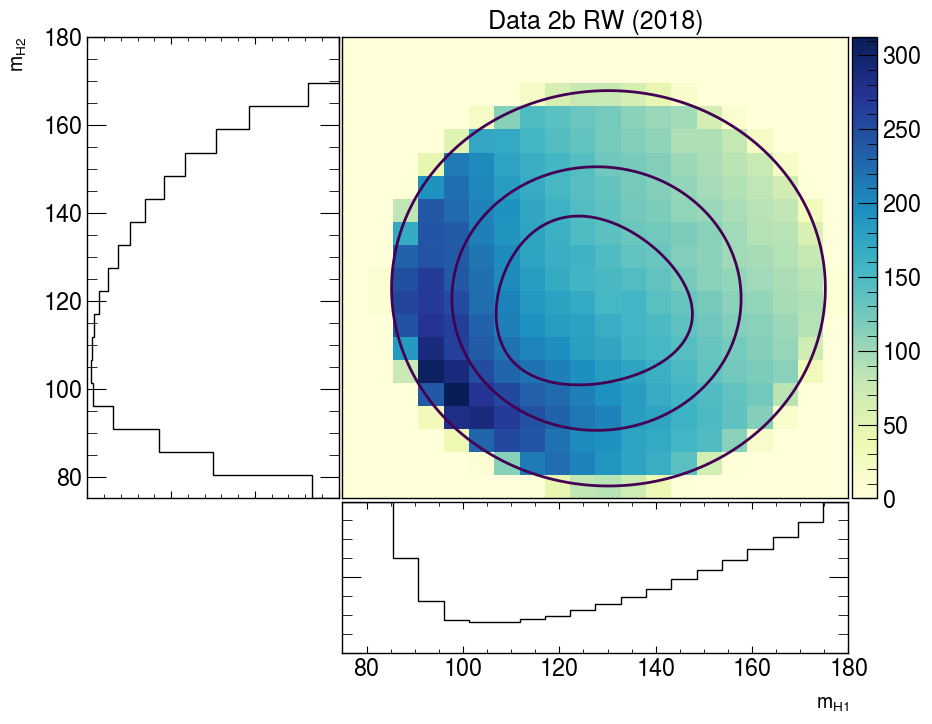

In [30]:
h_bkg = hist2d(
    data.loc[mask_data_2b, 'm_h1'].values,
    data.loc[mask_data_2b, 'm_h2'].values,
    xrange=(75, 180),
    yrange=(75, 180),
    bins=(20,20),
    weights = data.loc[mask_data_2b,'NN_weight'].values,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'Data 2b RW (2018)'
)
h_bkg['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45])
h_bkg['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30])
h_bkg['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6])
h_bkg['main_ax'].legend()

In [31]:
soverb = h_sig['h'] / h_bkg['h']

/mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [32]:
srootb = h_sig['h'] / np.sqrt(h_bkg['h'])

/mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [33]:
xedges = h_sig['xbins']

In [34]:
yedges = h_sig['ybins']

Text(0.5, 1.0, '$\\frac{signal}{background}$')

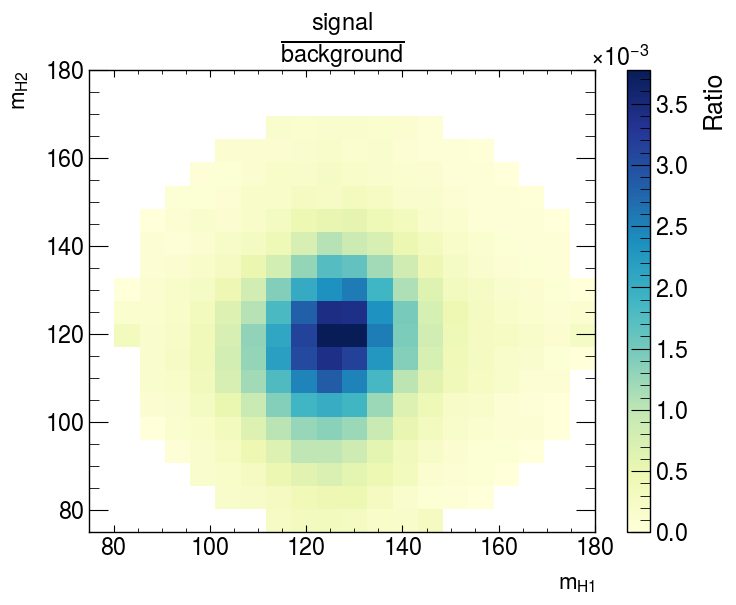

In [35]:
f, ax = plt.subplots()
_=hist2d_ratio(
    soverb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    colorbar=True
)
ax.set_title(r'$\frac{signal}{background}$')

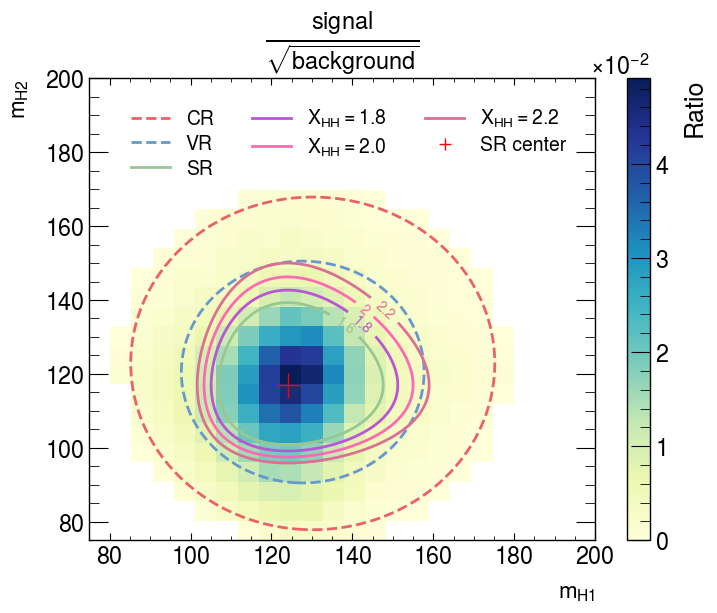

In [36]:
f, ax = plt.subplots()
_ = hist2d_ratio(
    srootb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel=r"$m_{H1}$",
    ylabel=r"$m_{H2}$",
    colorbar=True,
)
ax.set_title(r"$\frac{signal}{\sqrt{background}}$")
ax.contour(
    X,
    Y,
    crhh(X, Y, m_h1_center=124, m_h2_center=117),
    [45],
    linestyles="--",
    colors="#EC6067",
)
ax.contour(
    X,
    Y,
    vrhh(X, Y, m_h1_center=124, m_h2_center=117),
    [30],
    linestyles="--",
    colors="#6698CD",
)
cp16 = ax.contour(
    X, Y, xhh(X, Y, m_h1_center=124, m_h2_center=117), [1.6], colors="#99C794"
)
cp18 = ax.contour(
    X, Y, xhh(X, Y, m_h1_center=124, m_h2_center=117), [1.8], colors="mediumorchid"
)
cp20 = ax.contour(
    X, Y, xhh(X, Y, m_h1_center=124, m_h2_center=117), [2.0], colors="hotpink"
)
cp22 = ax.contour(
    X, Y, xhh(X, Y, m_h1_center=124, m_h2_center=117), [2.2], colors="palevioletred"
)
ax.clabel(cp16, inline=True, fontsize=10)
ax.clabel(cp18, inline=True, fontsize=10)
ax.clabel(cp20, inline=True, fontsize=10)
ax.clabel(cp22, inline=True, fontsize=10)
ax.plot(124,117, 'r+',markersize=18)
legend_elements = [
    Line2D([0], [0], color="#EC6067", label="CR", ls="--"),
    Line2D([0], [0], color="#6698CD", label="VR", ls="--"),
    Line2D([0], [0], color="#99C794", label="SR"),
    Line2D([0], [0], color="mediumorchid", label="$X_{HH}=1.8$"),
    Line2D([0], [0], color="hotpink", label="$X_{HH}=2.0$"),
    Line2D([0], [0], color="palevioletred", label="$X_{HH}=2.2$"),
    Line2D([0], [0], color='w',marker='+',label = "SR center",markeredgecolor='red')
]


ax.set_xlim((75, 200))
ax.set_ylim((75, 200))
ax.legend(handles=legend_elements, ncol=3)

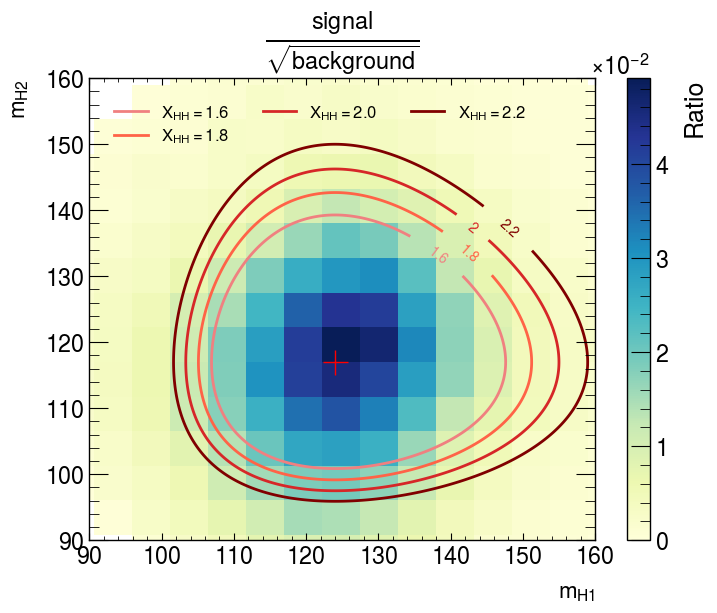

In [37]:
f, ax = plt.subplots()
_=hist2d_ratio(
    srootb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    colorbar=True
)
ax.set_title(r'$\frac{signal}{\sqrt{background}}$')
cp = ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='lightcoral')
ax.clabel(cp, inline=True, fontsize=10)
cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.8],colors='tomato')
ax.clabel(cp, inline=True, fontsize=10)
cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.0], colors='tab:red')
ax.clabel(cp, inline=True, fontsize=10)
cp=ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.2], colors='maroon')
ax.clabel(cp, inline=True, fontsize=10)
ax.plot(124,117, 'r+', markersize=18)
ax.set_xlim((90,160))
ax.set_ylim((90,160))

legend_elements = [
    Line2D([0],[0], color='lightcoral', label = '$X_{HH} = 1.6$'),
    Line2D([0], [0], color='tomato', label = '$X_{HH}=1.8$'),
    Line2D([0],[0], color='tab:red',label='$X_{HH}=2.0$'),
    Line2D([0],[0],color='maroon',label='$X_{HH}=2.2$')
]

ax.legend(handles=legend_elements, loc= 'upper left', fontsize = 12,ncol=3)


In [38]:
def circle(x, y, h, k):
    return np.sqrt((x-h)**2 + (y-k)**2)

<a list of 1 text.Text objects>

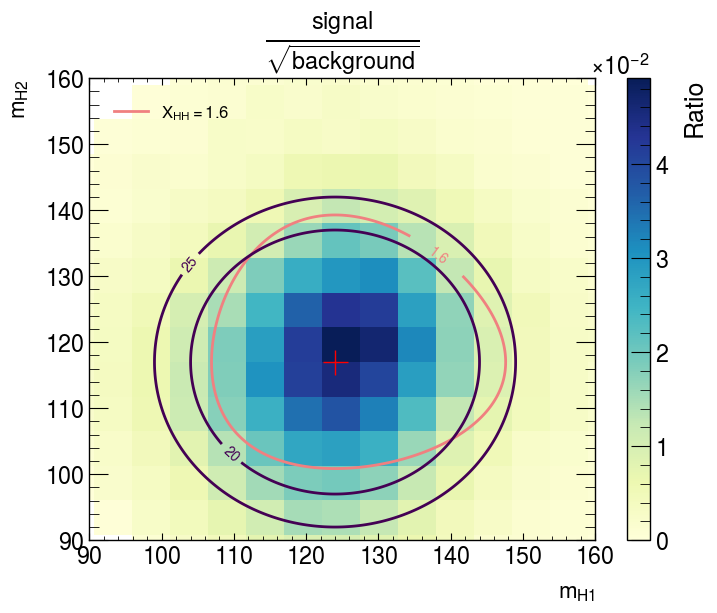

In [39]:
f, ax = plt.subplots()
_=hist2d_ratio(
    srootb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    colorbar=True
)
ax.set_title(r'$\frac{signal}{\sqrt{background}}$')
cp = ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='lightcoral')
ax.clabel(cp, inline=True, fontsize=10)
# cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.8],colors='tomato')
# ax.clabel(cp, inline=True, fontsize=10)
# cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.0], colors='tab:red')
# ax.clabel(cp, inline=True, fontsize=10)
# cp=ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.2], colors='maroon')
# ax.clabel(cp, inline=True, fontsize=10)
ax.plot(124,117, 'r+', markersize=18)
ax.set_xlim((90,160))
ax.set_ylim((90,160))

legend_elements = [
    Line2D([0],[0], color='lightcoral', label = '$X_{HH} = 1.6$'),
#     Line2D([0], [0], color='tomato', label = '$X_{HH}=1.8$'),
#     Line2D([0],[0], color='tab:red',label='$X_{HH}=2.0$'),
#     Line2D([0],[0],color='maroon',label='$X_{HH}=2.2$')
]

ax.legend(handles=legend_elements, loc= 'upper left', fontsize = 12,ncol=3)
cp = ax.contour(X, Y, circle(X,Y, 124, 117), [20])
ax.clabel(cp, inline=True, fontsize=10)
cp = ax.contour(X, Y, circle(X,Y, 124, 117), [25])
ax.clabel(cp, inline=True, fontsize=10)

# Elliptical Signal Region design 

In [1]:
h_sig = hist2d(
    signal.loc[mask_sig_4b, "m_h1"].values,
    signal.loc[mask_sig_4b, "m_h2"].values,
    xrange=(75, 180),
    yrange=(75, 180),
    bins=(20,20),
    axis_hist_on=True,
    weights=lumi * signal.loc[mask_sig_4b,'mc_sf'].values,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'Signal MC 4b (2018)'
)
h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45],)
h_sig['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30])
h_sig['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6])
h_sig['main_ax'].plot(124,117, 'r+', markersize=14)

legend_elements = [
    Line2D([0], [0], color="#EC6067", label="CR", ls="--"),
    Line2D([0], [0], color="#6698CD", label="VR", ls="--"),
    Line2D([0], [0], color="#99C794", label="SR"),

    Line2D([0], [0], color='w',marker='+',label = "SR center",markeredgecolor='red')
]


h_sig['main_ax'].legend()

NameError: name 'hist2d' is not defined

In [173]:
be = np.linspace(50, 200, 51)

Text(0.5, 1.0, 'massplane 1D projection')

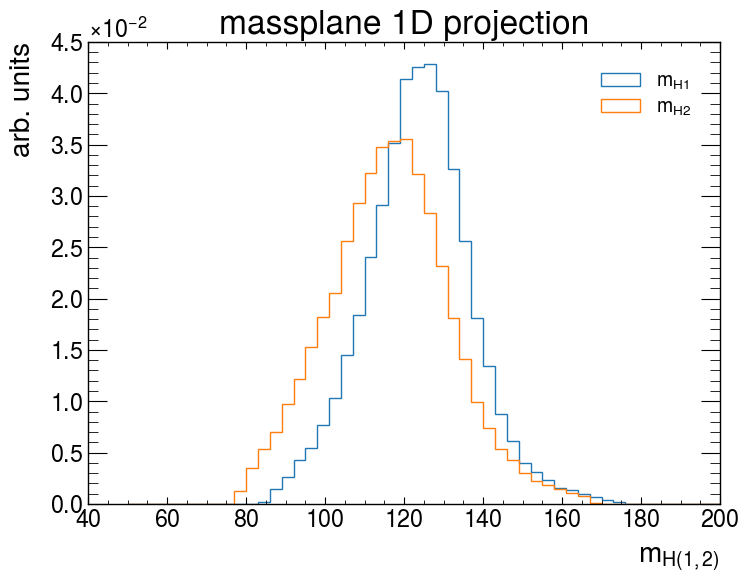

In [179]:
from statsmodels.stats.weightstats import DescrStatsW

In [189]:
import math

In [190]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [180]:
stats_mh1 = DescrStatsW(signal.loc[mask_sig_4b,'m_h1'].values, weights=signal.loc[mask_sig_4b,'mc_sf'].values, ddof=0)

In [182]:
stats_mh2 = DescrStatsW(signal.loc[mask_sig_4b,'m_h2'].values, weights=signal.loc[mask_sig_4b,'mc_sf'].values, ddof=0)

In [191]:
weighted_avg_and_std(signal.loc[mask_sig_4b,'m_h1'].values, signal.loc[mask_sig_4b,'mc_sf'].values)

(123.62275, 13.373100930270844)

In [183]:
stats_mh1.std

13.373102687908638

In [184]:
stats_mh2.std

15.415754838921234

In [181]:
stats_mh1.mean

123.62274898225338

In [217]:
stats_mh2.mean

116.30741233594138

In [192]:
stats_mh2.std/stats_mh1.std

1.1527433235713858

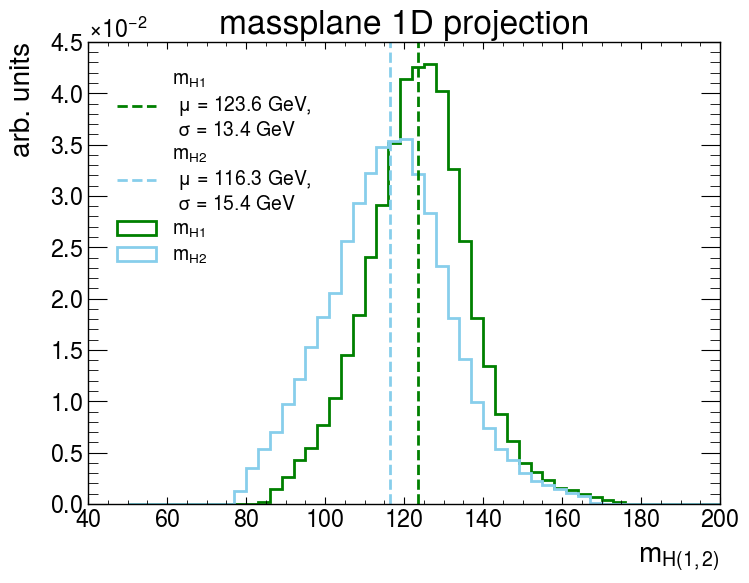

In [225]:
_ = plt.hist(
    signal.loc[mask_sig_4b, 'm_h1'].values,
    bins = be,
    weights = signal.loc[mask_sig_4b,'mc_sf'].values,
    histtype='step',
    label='$m_{H1}$',
    color='green',
    lw=2
)
_ = plt.hist(
    signal.loc[mask_sig_4b,'m_h2'].values,
    bins=be,
    weights=signal.loc[mask_sig_4b,'mc_sf'].values,
    histtype='step',
    label='$m_{H2}$',
    color='skyblue',
    lw=2
)
plt.xlabel('$m_{H(1,2)}$')
plt.ylabel('arb. units')
plt.title('massplane 1D projection')
plt.axvline(stats_mh1.mean, color='green', ls = '--', label ='$m_{H1}$ \n $\mu$ = 123.6 GeV,\n $\sigma$ = 13.4 GeV')
plt.axvline(stats_mh2.mean, color='skyblue', ls ='--', label ='$m_{H2}$ \n $\mu$ = 116.3 GeV,\n $\sigma$ = 15.4 GeV')
plt.legend(loc='upper left')


In [41]:
def ellipse(mh1, mh2, a, b):
    
    MH1 = ((mh1-124)**2)/(a**2)
    MH2 = ((mh2-117)**2)/(b**2)
    
    r = np.sqrt(MH1+MH2)
    
    return r

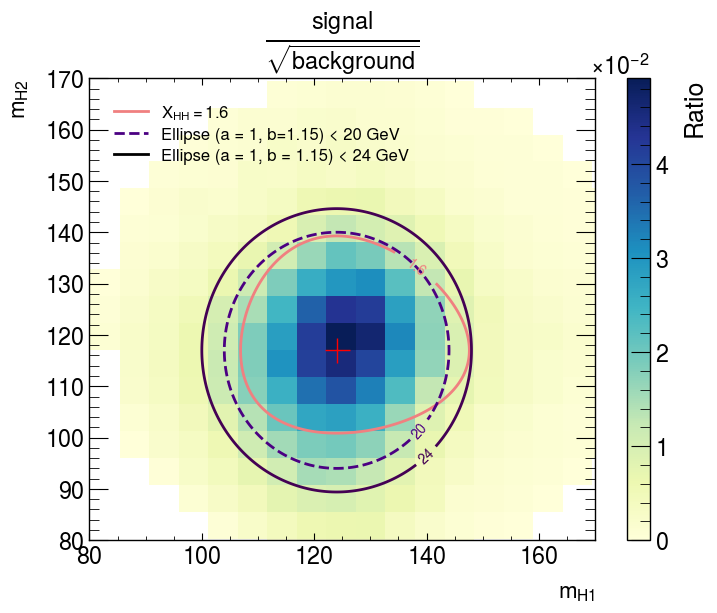

In [43]:
f, ax = plt.subplots()
_=hist2d_ratio(
    srootb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    colorbar=True
)
ax.set_title(r'$\frac{signal}{\sqrt{background}}$')
cp = ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='lightcoral')
ax.clabel(cp, inline=True, fontsize=10)
# cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.8],colors='tomato')
# ax.clabel(cp, inline=True, fontsize=10)
# cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.0], colors='tab:red')
# ax.clabel(cp, inline=True, fontsize=10)
# cp=ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.2], colors='maroon')
# ax.clabel(cp, inline=True, fontsize=10)
ax.plot(124,117, 'r+', markersize=18)
ax.set_xlim((80,170))
ax.set_ylim((80,170))

legend_elements = [
    Line2D([0],[0], color='lightcoral', label = '$X_{HH} = 1.6$'),
    Line2D([0], [0], color='indigo', ls='--', label = 'Ellipse (a = 1, b=1.15) < 20 GeV'),
    Line2D([0],[0], color='black',label='Ellipse (a = 1, b = 1.15) < 24 GeV'),
#     Line2D([0],[0],color='maroon',label='$X_{HH}=2.2$')
]

cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [24])
ax.clabel(cp, inline=True, fontsize=10)
cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [20],colors ='indigo',linestyles='--')
ax.clabel(cp, inline=True, fontsize=10)

ax.legend(handles=legend_elements, loc= 'upper left', fontsize = 12)


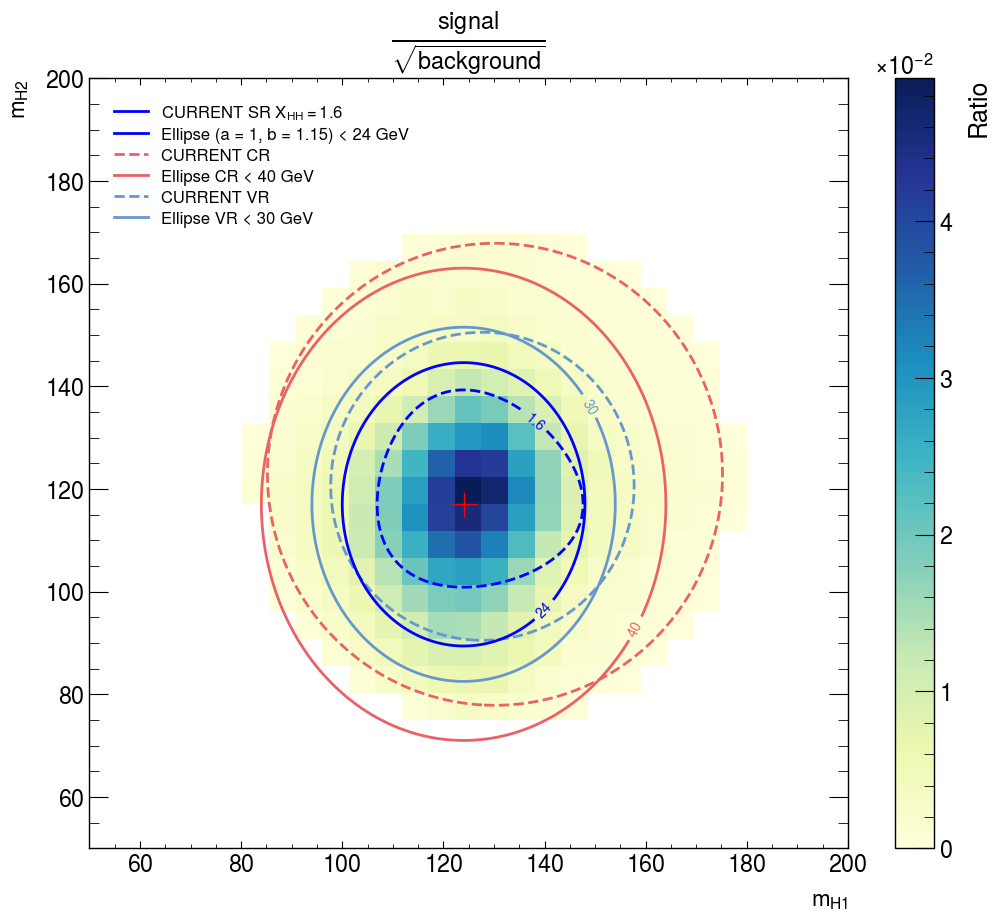

In [44]:
f, ax = plt.subplots(figsize = (12,10))
_=hist2d_ratio(
    srootb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    colorbar=True
)
ax.contour(
    X,
    Y,
    crhh(X, Y, m_h1_center=124, m_h2_center=117),
    [45],
    linestyles="--",
    colors="#EC6067",
)
ax.contour(
    X,
    Y,
    vrhh(X, Y, m_h1_center=124, m_h2_center=117),
    [30],
    linestyles="--",
    colors="#6698CD",
)
ax.set_title(r'$\frac{signal}{\sqrt{background}}$')
cp = ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='blue', linestyles='--')
ax.clabel(cp, inline=True, fontsize=10)
# cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.8],colors='tomato')
# ax.clabel(cp, inline=True, fontsize=10)
# cp= ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.0], colors='tab:red')
# ax.clabel(cp, inline=True, fontsize=10)
# cp=ax.contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [2.2], colors='maroon')
# ax.clabel(cp, inline=True, fontsize=10)
ax.plot(124,117, 'r+', markersize=18)
ax.set_xlim((50,200))
ax.set_ylim((50,200))

legend_elements = [
    Line2D([0],[0], color='blue', label = 'CURRENT SR $X_{HH} = 1.6$'),
#     Line2D([0], [0], color='indigo', ls='--', label = 'Ellipse (a = 1, b=1.15) < 20 GeV'),
    Line2D([0],[0], color='blue',label='Ellipse (a = 1, b = 1.15) < 24 GeV'),
    Line2D([0], [0], color="#EC6067", label="CURRENT CR", ls="--"),
    Line2D([0], [0], color="#EC6067", label="Ellipse CR < 40 GeV",),
    Line2D([0], [0], color="#6698CD", label="CURRENT VR", ls="--"),
    Line2D([0], [0], color="#6698CD", label="Ellipse VR < 30 GeV"),

#     Line2D([0], [0], color="#99C794", label="SR"),
#     Line2D([0],[0],color='maroon',label='$X_{HH}=2.2$')
]

cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
# cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [20],colors ='indigo',linestyles='--')
# ax.clabel(cp, inline=True, fontsize=10)
cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [30],colors ='#6698CD',linewidths=[2])
ax.clabel(cp, inline=True, fontsize=10)
cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [40],colors ='#EC6067')
ax.clabel(cp, inline=True, fontsize=10)

ax.legend(handles=legend_elements, loc= 'upper left', fontsize = 12)


# Expand to analyse the fullmassplane! 

In [255]:
file_path_data_fmp_18  = '/mnt/storage/lborgna/NNT/MDR_VEC/data/data_2B_SRshift_fmp_16.root'

In [271]:
sig_fmp = load_nnt(file_path_mc_18, trees=["fullmassplane"], columns=columns_to_load+['mc_sf'])

100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


In [321]:
data_fmp = load_nnt(
    file_path_data_fmp_18,
    trees=["fullmassplane"],
)

100%|██████████| 219/219 [03:40<00:00,  1.01s/it]


No handles with labels found to put in legend.


<a list of 1 text.Text objects>

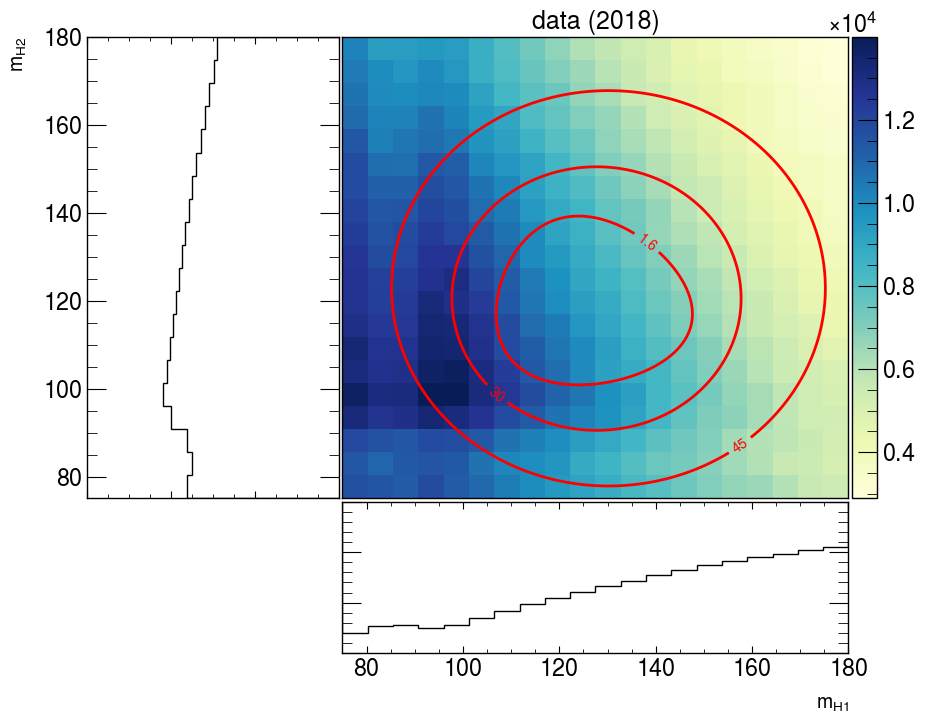

In [263]:
h_sig = hist2d(
    data_fmp["m_h1"].values,
    data_fmp["m_h2"].values,
    xrange=(75, 180),
    yrange=(75, 180),
    bins=(20,20),
    axis_hist_on=True,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'data (2018)'
)
cp = h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45],colors='red')
ax.clabel(cp,inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30],colors='red')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='red')
ax.clabel(cp, inline=True, fontsize = 10)
h_sig['main_ax'].legend()

cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)

No handles with labels found to put in legend.


<a list of 1 text.Text objects>

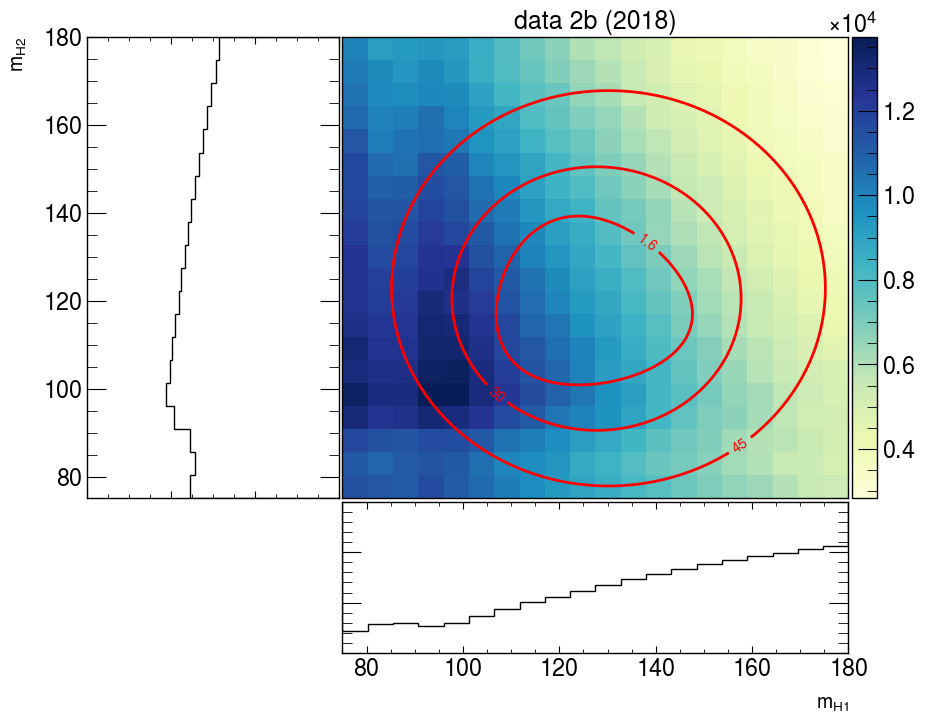

In [265]:
h_sig = hist2d(
    data_fmp.loc[data_fmp['ntag']==2,"m_h1"].values,
    data_fmp.loc[data_fmp['ntag']==2,"m_h2"].values,
    xrange=(75, 180),
    yrange=(75, 180),
    bins=(20,20),
    axis_hist_on=True,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'data 2b (2018)'
)
cp = h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45],colors='red')
ax.clabel(cp,inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30],colors='red')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='red')
ax.clabel(cp, inline=True, fontsize = 10)
h_sig['main_ax'].legend()

cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)

No handles with labels found to put in legend.


<a list of 1 text.Text objects>

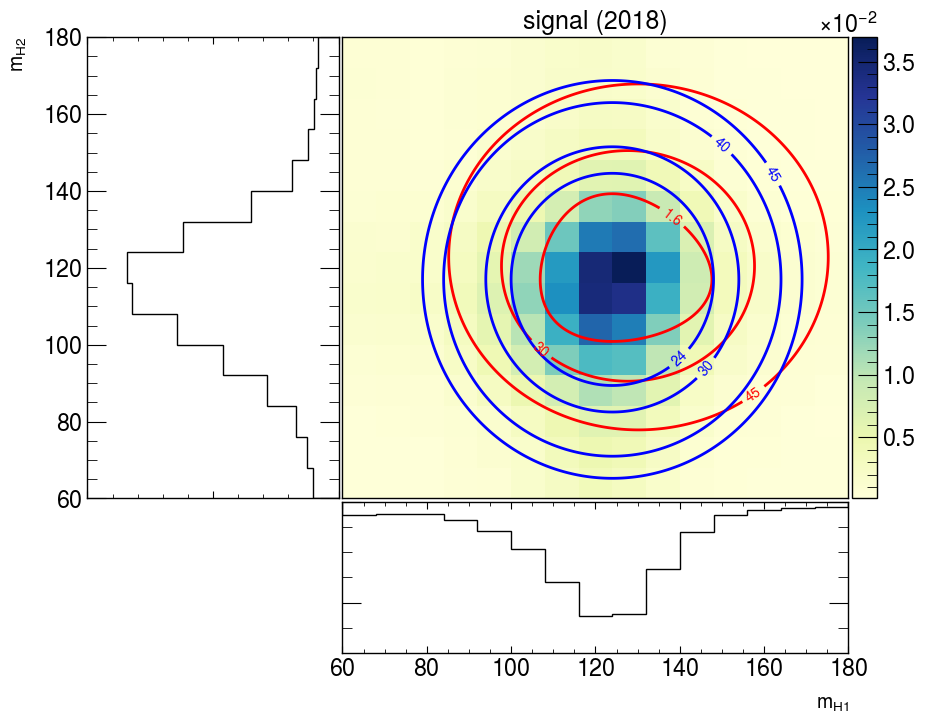

In [307]:
h_sig = hist2d(
    sig_fmp["m_h1"].values,
    sig_fmp["m_h2"].values,
    xrange=(60, 180),
    yrange=(60, 180),
    bins=(15,15),
    axis_hist_on=True,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'signal (2018)',
    weights = sig_fmp['mc_sf'].values
)
cp = h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45],colors='red')
ax.clabel(cp,inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30],colors='red')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='red')
ax.clabel(cp, inline=True, fontsize = 10)
h_sig['main_ax'].legend()

cp = ax.contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [40], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [45], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [30], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)

No handles with labels found to put in legend.


<a list of 1 text.Text objects>

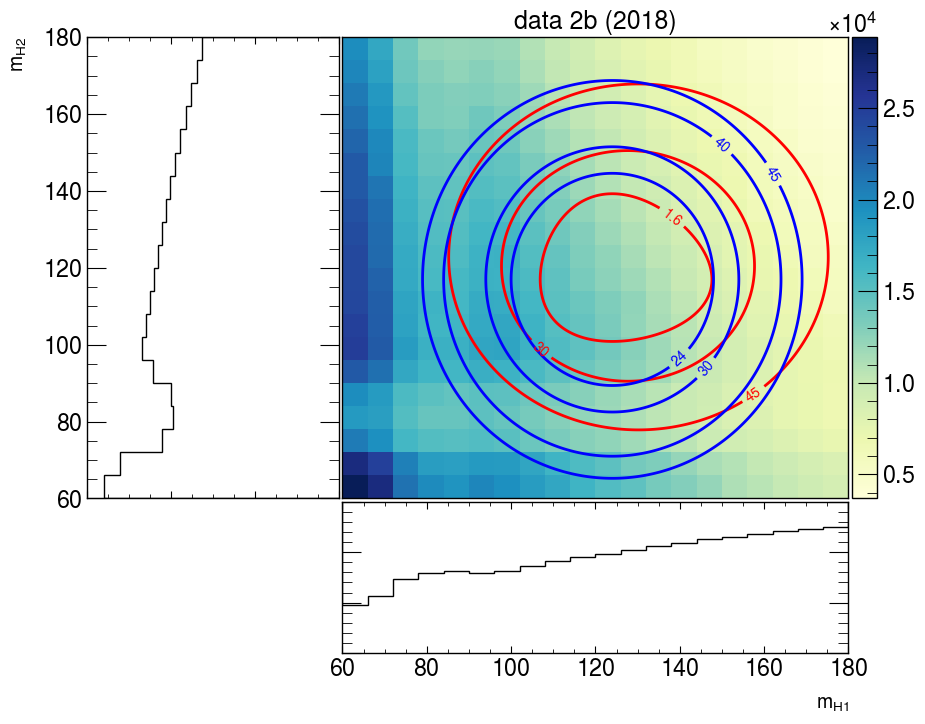

In [293]:
h_sig = hist2d(
    data_fmp.loc[data_fmp['ntag']==2,"m_h1"].values,
    data_fmp.loc[data_fmp['ntag']==2,"m_h2"].values,
    xrange=(60, 180),
    yrange=(60, 180),
    bins=(20,20),
    axis_hist_on=True,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'data 2b (2018)'
)
cp = h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45],colors='red')
ax.clabel(cp,inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30],colors='red')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='red')
ax.clabel(cp, inline=True, fontsize = 10)
h_sig['main_ax'].legend()

cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [40], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [45], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [30], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)

No handles with labels found to put in legend.


<a list of 1 text.Text objects>

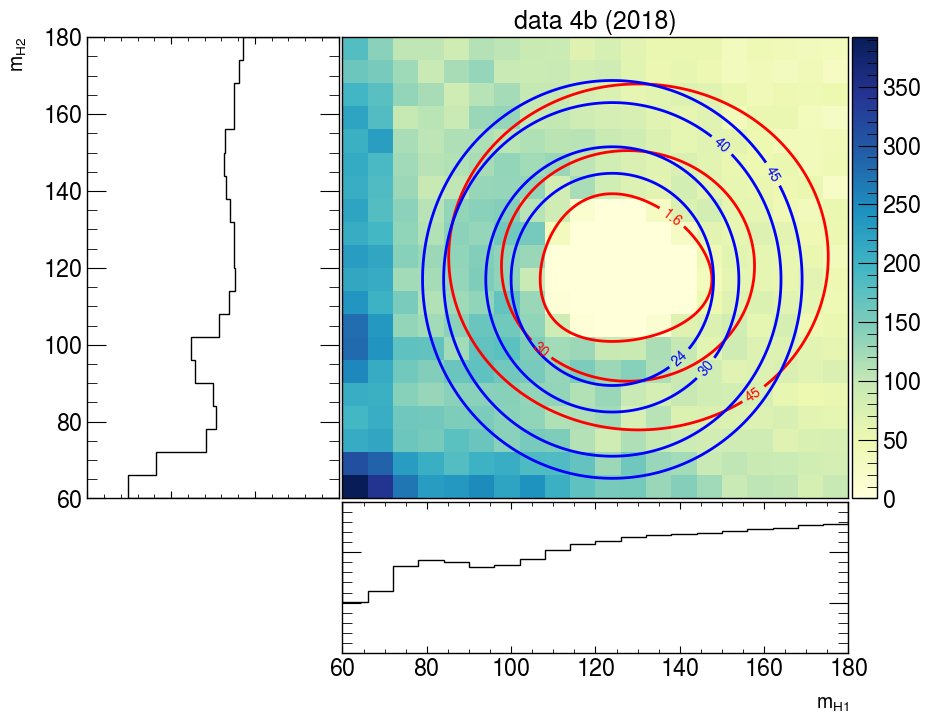

In [319]:
h_sig = hist2d(
    data_fmp.loc[data_fmp['ntag']>=4,"m_h1"].values,
    data_fmp.loc[data_fmp['ntag']>=4,"m_h2"].values,
    xrange=(60, 180),
    yrange=(60, 180),
    bins=(20,20),
    axis_hist_on=True,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'data 4b (2018)'
)
cp = h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45],colors='red')
ax.clabel(cp,inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, vrhh(X,Y, m_h1_center=124, m_h2_center=117), [30],colors='red')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, xhh(X,Y, m_h1_center=124, m_h2_center=117), [1.6],colors='red')
ax.clabel(cp, inline=True, fontsize = 10)
h_sig['main_ax'].legend()

cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [40], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [45], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [30], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)

<a list of 2 text.Text objects>

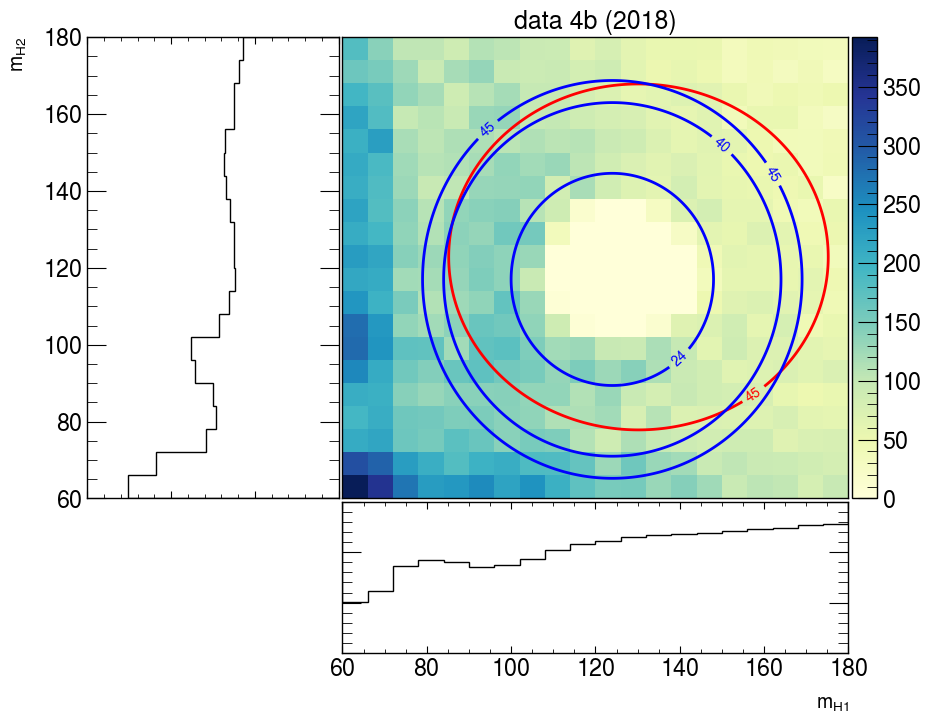

In [320]:
h_sig = hist2d(
    data_fmp.loc[data_fmp['ntag']>=4,"m_h1"].values,
    data_fmp.loc[data_fmp['ntag']>=4,"m_h2"].values,
    xrange=(60, 180),
    yrange=(60, 180),
    bins=(20,20),
    axis_hist_on=True,
    xlabel = r'$m_{H1}$',
    ylabel = r'$m_{H2}$',
    title = 'data 4b (2018)'
)
cp = h_sig['main_ax'].contour(X, Y, crhh(X,Y, m_h1_center=124, m_h2_center=117), [45],colors='red')
ax.clabel(cp,inline=True, fontsize=10)


cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [24], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [40], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
cp = h_sig['main_ax'].contour(X, Y, ellipse(X,Y, 1, 1.15), [45], colors='blue')
ax.clabel(cp, inline=True, fontsize=10)
ax.clabel(cp, inline=True, fontsize=10)

# Cutflow Analysis

In [309]:
CR_old_mask = (xhh(data_fmp["m_h1"], data_fmp["m_h2"], 124, 117) >= 1.6) & (
    crhh(data_fmp["m_h1"], data_fmp["m_h2"], 124, 117) <= 45
)
CR_old_new_sr = (crhh(data_fmp["m_h1"], data_fmp["m_h2"], 124, 117) <= 45) & (
    ellipse(data_fmp["m_h1"], data_fmp["m_h2"], 1, 1.15) > 24
)

CR_new_mask40 = (ellipse(data_fmp["m_h1"], data_fmp["m_h2"], 1, 1.15) <= 40) & (
    ellipse(data_fmp["m_h1"], data_fmp["m_h2"], 1, 1.15) > 24
)
CR_new_mask45 = (ellipse(data_fmp["m_h1"], data_fmp["m_h2"], 1, 1.15) <= 45) & (
    ellipse(data_fmp["m_h1"], data_fmp["m_h2"], 1, 1.15) > 24
)

In [310]:
N4b_data_old = data_fmp.loc[(data_fmp['ntag']>=4)&CR_old_mask].shape[0]
N4b_data_old_new = data_fmp.loc[(data_fmp['ntag']>=4) & CR_old_new_sr].shape[0]
N4b_data_new40 = data_fmp.loc[(data_fmp['ntag']>=4)&CR_new_mask40].shape[0]
N4b_data_new45 = data_fmp.loc[(data_fmp['ntag']>=4) &CR_new_mask45].shape[0]

In [311]:
print(N4b_data_old,N4b_data_old_new,N4b_data_new40, N4b_data_new45)

13613 10803 10673 15022


In [312]:
CR_old_mask = (xhh(sig_fmp["m_h1"], sig_fmp["m_h2"], 124, 117) >= 1.6) & (
    crhh(sig_fmp["m_h1"], sig_fmp["m_h2"], 124, 117) <= 45
)
CR_old_new_sr = (crhh(sig_fmp["m_h1"], sig_fmp["m_h2"], 124, 117) <= 45) & (
    ellipse(sig_fmp["m_h1"], sig_fmp["m_h2"], 1, 1.15) > 24
)
CR_new_mask40 = (ellipse(sig_fmp["m_h1"], sig_fmp["m_h2"], 1, 1.15) <= 40) & (
    ellipse(sig_fmp["m_h1"], sig_fmp["m_h2"], 1, 1.15) > 24
)
CR_new_mask45 = (ellipse(sig_fmp["m_h1"], sig_fmp["m_h2"], 1, 1.15) <= 45) & (
    ellipse(sig_fmp["m_h1"], sig_fmp["m_h2"], 1, 1.15) > 24
)

In [313]:
N4b_sig_old = sig_fmp.loc[(sig_fmp['ntag']>=4)&CR_old_mask].shape[0]
N4b_sig_old_new = sig_fmp.loc[(sig_fmp['ntag']>=4) & CR_old_new_sr].shape[0]
N4b_sig_new40 = sig_fmp.loc[(sig_fmp['ntag']>=4)&CR_new_mask40].shape[0]
N4b_sig_new45 = sig_fmp.loc[(sig_fmp['ntag']>=4) &CR_new_mask45].shape[0]

In [314]:
print(N4b_sig_old,N4b_sig_old_new,N4b_sig_new40, N4b_sig_new45)

27185 14157 14912 16950


In [317]:
N4b_sig_old = lumi*sig_fmp.loc[(sig_fmp['ntag']>=4)&CR_old_mask,'mc_sf'].sum()
N4b_sig_old_new = lumi*sig_fmp.loc[(sig_fmp['ntag']>=4) & CR_old_new_sr,'mc_sf'].sum()

N4b_sig_new40 = lumi*sig_fmp.loc[(sig_fmp['ntag']>=4)&CR_new_mask40,'mc_sf'].sum()
N4b_sig_new45 = lumi*sig_fmp.loc[(sig_fmp['ntag']>=4) &CR_new_mask45,'mc_sf'].sum()

In [318]:
print(N4b_sig_old,N4b_sig_old_new,N4b_sig_new40, N4b_sig_new45)

10.375066300481558 5.353579337894916 5.637176379188896 6.438697003200651


# Reweighting New and old CRs

In [326]:
data_fmp = data_fmp[~data_fmp.pass_vbf_sel].reset_index(drop=True)

In [327]:
data_fmp.head()

run_number  event_number  pass_vbf_sel  mc_sf  trig_sf  jet_trig_sfs  \
0      298773        988881         False    1.0      1.0           1.0   
1      298773        801327         False    1.0      1.0           1.0   
2      298773       1150174         False    1.0      1.0           1.0   
3      298773       1000770         False    1.0      1.0           1.0   
4      298773       1693750         False    1.0      1.0           1.0   

   truth_mhh  ntag  njets  kinematic_region  ...  tagged_vbf_j1  m_vbf_j2  \
0        0.0     2      4                 3  ...          False       0.0   
1        0.0     2      4                 3  ...          False       0.0   
2        0.0     2      4                 0  ...          False       0.0   
3        0.0     2      4                 3  ...          False       0.0   
4        0.0     2      4                 1  ...          False       0.0   

   E_vbf_j2  pT_vbf_j2  eta_vbf_j2  phi_vbf_j2  tagged_vbf_j2  vbf_mjj  \
0       0.0        0.0         0.0         0.0          False      0.0   
1       0.0        0.0         0.0         0.0          False      0.0   
2       0.0        0.0         0.0         0.0          False      0.0   
3       0.0        0.0         0.0         0.0          False      0.0   
4       0.0        0.0         0.0         0.0          False      0.0   

   vbf_dEtajj  vbf_pTvecsum  
0         0.0           0.0  
1         0.0           0.0  
2         0.0           0.0  
3         0.0           0.0  
4         0.0           0.0  

[5 rows x 89 columns]

In [344]:
data_fmp['kr_original'] = data_fmp['kinematic_region']

In [328]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

In [329]:
calculatedRhh(data_fmp)
calculatedPhi(data_fmp)

In [333]:
mask_SR = (ellipse(data_fmp['m_h1'],data_fmp['m_h2'],1,1.15) <=24)

In [334]:
mask_SR.value_counts()

False    17782586
True       706775
dtype: int64

In [335]:
mask_CRnew = (ellipse(data_fmp['m_h1'],data_fmp['m_h2'], 1, 1.15)> 24) & (ellipse(data_fmp['m_h1'],data_fmp['m_h2'], 1, 1.15) <= 40)

In [337]:
mask_CRnew.value_counts()

False    17308138
True      1181223
dtype: int64

In [338]:
data_fmp.loc[mask_SR, 'kr_new'] = 0 
data_fmp.loc[mask_CRnew,'kr_new'] = 2

In [339]:
mask_CRold = (~mask_SR) & (crhh(data_fmp['m_h1'],data_fmp['m_h2'], 124, 117) < 45)

In [340]:
data_fmp.loc[mask_SR, 'kr_old'] = 0
data_fmp.loc[mask_CRold, 'kr_old'] =2

In [ ]:
data

In [331]:

from eda_tools import NN_RW as nn

In [332]:
nominal = nn.nominal()

In [341]:
rw_cols_to_log = nominal['rw_cols_to_log']
rw_cols_log = nominal['rw_cols_log']

In [342]:
rw_cols_to_log[-1] = 'X_wt_tag'
rw_cols_log[-4] = 'X_wt_tag_log'

In [343]:
nn.log_inputs(data_fmp, to_log=rw_cols_to_log)

In [345]:
data_fmp['kinematic_region'] = data_fmp['kr_new']

In [346]:
df_w, mu_bs = nn.repeatNNtrain(
    data_fmp,
    repeat=100,
    kinematic_region=2,
    sort_rw_cols=rw_cols_log,
    epochs=500,
    save=True,
    batch_size=10000,
    model_storage_directory='/mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/',
)

  0%|          | 0/100 [00:00<?, ?it/s]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Epoch 1/500


  0%|          | 0/100 [01:33<?, ?it/s]


TypeError: in user code:

    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    ../../eda_tools/NN_RW.py:22 louppe_loss  *
        return (y_true * (K.sqrt(K.exp(y_pred))) + (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))
    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1180 binary_op_wrapper
        raise e
    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1496 _mul_dispatch
        return multiply(x, y, name=name)
    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:518 multiply
        return gen_math_ops.mul(x, y, name)
    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6078 mul
        "Mul", x=x, y=y, name=name)
    /mnt/storage/lborgna/condaenv/py38/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:558 _apply_op_helper
        inferred_from[input_arg.type_attr]))

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.
